# Import Data
1. Import data as a table
2. Add column names into the table

- **OTSV1** : 3 way valve %
- **TV12**  : Inlet Temp to Gearbox
- **TV11**  : Outlet Temp from Gearbox
- **OTGT1** : Inlet Temp to Heat Exchanger

In [3]:
T_data = readtable('C:\Users\jerem\Documents\Python Scripts\Scania\Test_Data\Partition_Data\D_47414.csv');

T_data.Properties.VariableNames = {'OTSV1', 'TV12', 'TV11'};

## Data Augmentation
Reversing the table order for testing dataset.

In [4]:
T_test = flip(T_data);

Size: $\frac{Train}{Test} = \frac{1}{1}$

In [5]:
u_train = table2array(T_data(:, 1));   % OTSV1
y_train = table2array(T_data(:, 2));   % TV12

u_test =  table2array(T_test(:, 1));   % OTSV1
y_test =  table2array(T_test(:, 2));   % TV12

## Create iddata object for Training and Testing
In this system identification:
- **Input**  : OTSV1 (3 way valve %)
- **Output** : TV12 (Inlet Temp to Gearbox)

> data = iddata(*input*, *ouput*, *sampling time*)

In [6]:
Ts = 0.2;  % second

In [10]:
%% Training Data
data_train = iddata(y_train, u_train, Ts);

data_train.Name = 'Data_Train';
data_train.TimeUnit = 'seconds';

data_train.InputName = 'OTSV1';   data_train.InputUnit = 'Percentage';
data_train.OutputName = 'TV12';   data_train.OutputUnit = 'Celsius';

%% Testing Data
data_test = iddata(y_test, u_test, Ts);

data_test.Name = 'Data_Test';
data_test.TimeUnit = 'seconds';

data_test.InputName = 'OTSV1';   data_test.InputUnit = 'Percentage';
data_test.OutputName = 'TV12';   data_test.OutputUnit = 'Celsius';

%% Print Data
get(data_train)


ans = 

  struct with fields:

              Domain: 'Time'
                Name: 'Data_Train'
          OutputData: [9171x1 double]
                   y: 'Same as OutputData'
          OutputName: {'TV12'}
          OutputUnit: {'Celsius'}
           InputData: [9171x1 double]
                   u: 'Same as InputData'
           InputName: {'OTSV1'}
           InputUnit: {'Percentage'}
              Period: Inf
         InterSample: 'zoh'
                  Ts: 0.2000
              Tstart: []
    SamplingInstants: [9171x0 double]
            TimeUnit: 'seconds'
      ExperimentName: 'Exp1'
               Notes: {}
            UserData: []




## Plot Data
- Plot Above: Output (TV12:  Inlet Temp to Gearbox)
- Plot Below: Input  (OTSV1: 3 way valve %)

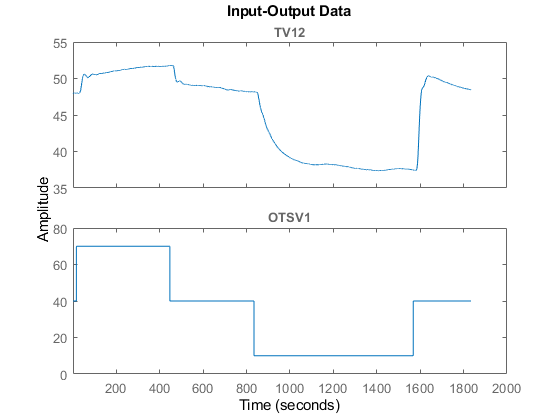

In [11]:
plot(data_train)

## Check Nonlinearity

In [9]:
advice(data_train, 'nonlinearity')

There is an indication of nonlinearity in the data.
A nonlinear ARX model of order [4 4 1] and treepartition nonlinearity estimator 
performs better prediction of output than the corresponding ARX model of the 
same order. Consider using nonlinear models, such as IDNLARX, or IDNLHW. You 
may also use the "isnlarx" command to test for nonlinearity with more options.




# Data Pre-process

## Detrend Data

Removing offset or linear trends

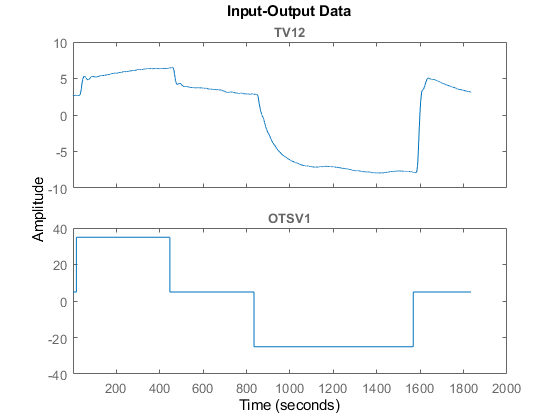

In [81]:
data_train = detrend(data_train);
data_test = detrend(data_test);
plot(data_train)

## Filter Data

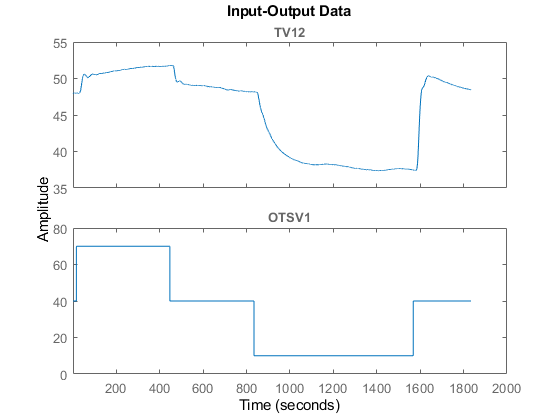

In [28]:
data_train_filter = idfilt(data_train, [0 1]); %butter worth bandpass filter with 0-1 hz 
plot(data_train)

# SI: TF Model

**sysTF = tfest(*data*, *Num of Poles*, *Num of Zeros*)** $\quad$ ([link](https://se.mathworks.com/help/ident/ref/tfest.html))

## Set estimation options

In [88]:
opt = tfestOptions;
opt.InitializeMethod = 'all';
opt.SearchOptions.MaxIterations = 1000; 

## Estimate TF model

In [89]:
np = 5;          % Num of pole
nz = 4;          % Num of zero
iodelay = 20.0;   % In/Out delay

sysTF = tfest(data_train, np, nz, opt)


sysTF =
 
  From input "OTSV1" to output "TV12":
   -0.01123 s^4 - 0.0004548 s^3 - 0.0004032 s^2 + 4.932e-05 s + 4.45e-07
  -----------------------------------------------------------------------
  s^5 + 0.3092 s^4 + 0.07135 s^3 + 0.007191 s^2 + 0.0003312 s + 1.849e-06
 
Continuous-time identified transfer function.

Parameterization:
   Number of poles: 5   Number of zeros: 4
   Number of free coefficients: 10
   Use "tfdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                
Estimated using TFEST on time domain data "Data_Train".
Fit to estimation data: 65.26%                         
FPE: 3.875, MSE: 3.862                                 



In [90]:
sysTF.Report.Fit


ans = 

  struct with fields:

    FitPercent: 65.2554
       LossFcn: 4.2748
           MSE: 3.8620
           FPE: 3.8746
           AIC: 3.8448e+04
          AICc: 3.8448e+04
          nAIC: 1.3544
           BIC: 3.8555e+04




## Advice on the estimated model

In [91]:
advice(sysTF, data_test)

                                                                                                                                                                                                                                                                                                                              
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                                                              
A first general advice is to run RESID(VDAT

## Error Analysis TF Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [92]:
% generate reference output
y_tf_ref = data_train.y;

% generate estimated output
y_tf_est = sim(sysTF, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_tf_est.y, y_tf_ref, cost_func)


fit =

    0.3707




#### Compare

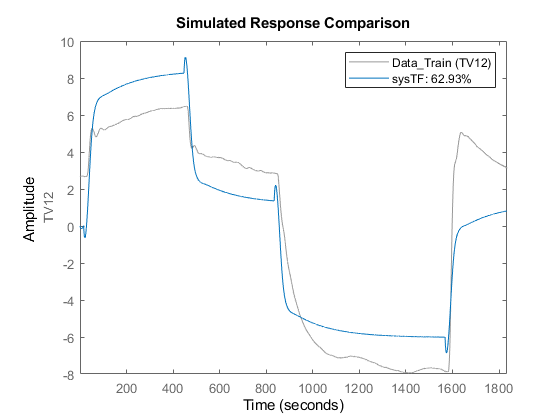

In [93]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysTF, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

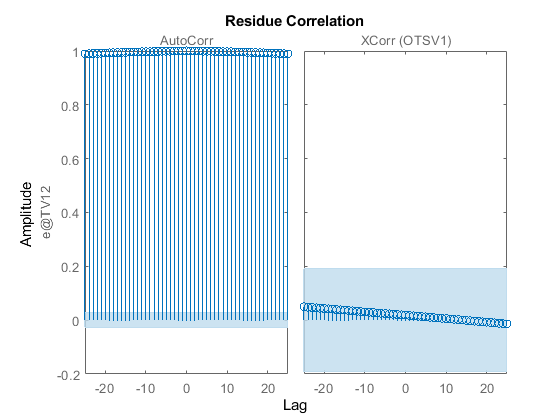

In [94]:
resid(data_test,sysTF)

# SI: SS Model

**sysSS = ssest(*data*, *Num of Poles*, *Num of Zeros*)** $\quad$ ([link](https://se.mathworks.com/help/ident/ref/ssest.html))

## Estimate SS Model

For state space model, there are two ways of determining the system order <br>
1. **By specifying the system order with paramter $nx$ with custom estimation options**
2. Don't specify it. The program will automatically find the best order with least error

### Estimate SS model with order selection ([link](https://se.mathworks.com/help/ident/ug/estimate-state-space-model-with-order-selection.html))
There different functions can be used here. **n4sid** & **ssregest** construct a discrete-time model, **ssest** constructs a continuous-time model <br>
1. n4sid(data, n1:n2)
> n1:n2 is the range of orders to try <br>
> Ex. model = n4sid(data, n1:n2)

2. ssest(data, nn)
> nn is the range of orders to try     <br>
> Ex. model = ssest(data, nn, 'Ts', data.Ts) <br>

3. ssregest(data, nn)
> nn is the range of orders to try     <br>
> Ex. model = ssregest(data, nn, 'Ts', data.Ts) <br>

In [130]:
CoarseOrderSearch = [1, 2, 3, 4, 5, 6, 7, 8];
%sysSS = ssest(data_train, CoarseOrderSearch, 'Ts', data_train.Ts)
%sysSS = ssregest(data_train, CoarseOrderSearch, 'Ts', data_train.Ts)
sysSS = n4sid(data_train, CoarseOrderSearch)


sysSS =
  Discrete-time identified state-space model:
    x(t+Ts) = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
              x1         x2
   x1     0.9987  -0.004597
   x2   0.005599     0.9962
 
  B = 
            OTSV1
   x1  -6.985e-08
   x2  -5.888e-06
 
  C = 
              x1       x2
   TV12    260.6  -0.5551
 
  D = 
         OTSV1
   TV12      0
 
  K = 
           TV12
   x1  0.001079
   x2    -0.064
 
Sample time: 0.2 seconds
  
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 10
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                
Estimated using N4SID on time domain data "Data_Train".
Fit to estimation data: 99.78% (prediction focus)      
FPE: 0.0001589, MSE: 0.0001586                         



For state space model, there are two ways of determining the system order <br>
1. By specifying the system order with paramter $nx$ with custom estimation options
2. **Don't specify it. The program will automatically find the best order with least error**

In [127]:
sysSS = ssest(data_train)


sysSS =
  Continuous-time identified state-space model:
      dx/dt = A x(t) + B u(t) + K e(t)
       y(t) = C x(t) + D u(t) + e(t)
 
  A = 
              x1         x2
   x1  -0.004855    0.02646
   x2   -0.02489   -0.02328
 
  B = 
            OTSV1
   x1    3.24e-07
   x2  -2.576e-05
 
  C = 
             x1      x2
   TV12  -260.6  -0.417
 
  D = 
         OTSV1
   TV12      0
 
  K = 
            TV12
   x1  -0.004887
   x2    -0.3224
 
Parameterization:
   FREE form (all coefficients in A, B, C free).
   Feedthrough: none
   Disturbance component: estimate
   Number of free coefficients: 10
   Use "idssdata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                
Estimated using SSEST on time domain data "Data_Train".
Fit to estimation data: 99.78% (prediction focus)      
FPE: 0.000158, MSE: 0.0001578                          



## Advice on the estimated model

In [131]:
advice(sysSS, data_test)

                                                                                                                                                                                                                        
There is no indication of significant errors in the model dynamics.                                                                                                                                                     
                                                                                                                                                                                                                        
There is a very strong indication that the residuals are not white. To get a 
good noise model you need to increase the orders associated with the noise 
parameters, or just increase the order of a state-space model.
                                                                                                                                    

## Error Analysis SS Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [132]:
% generate reference output
y_ss_ref = data_train.y;

% generate estimated output
y_ss_est = sim(sysSS, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_ss_est.y, y_ss_ref, cost_func)


fit =

    0.4051




#### Compare

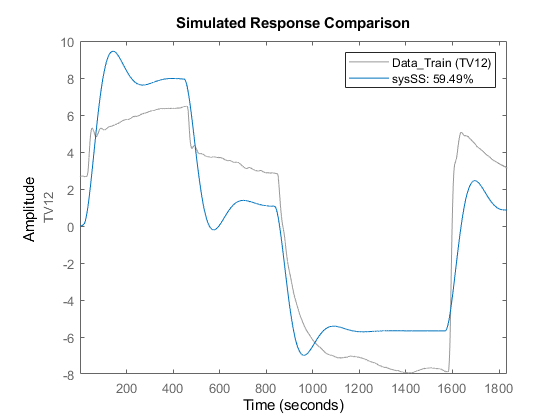

In [133]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysSS, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

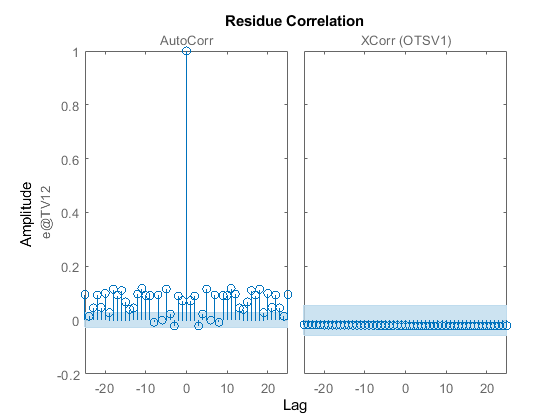

In [134]:
resid(data_test,sysSS)

# SI: ARX Model

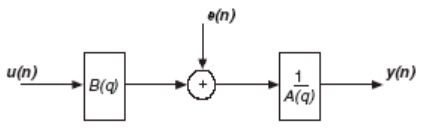 <br>
**sysARX = arx(data, [na, nb, nk])** $\quad$ ([link](https://se.mathworks.com/help/ident/ref/arx.html))
> na: Order of A(q)  <br>
> nb: Order of B(q)+1  <br>
> nk: Input-Output delay  <br>

## Set estimation options

In [95]:
opt = arxOptions;
opt.Focus = 'prediction';

## Coarse search model order

We can use **[arxstruc()](https://se.mathworks.com/help/ident/ref/arxstruc.html)** and **[selstruc()](https://se.mathworks.com/help/ident/ref/selstruc.html)** to find a suggested ARX model structure
* arxstruc(estimation_data, validation_data, range )
> range = [na nb nk] <br>
> is the selected range of na, nb, nk <br>
> Ex: V = arxstruc(ze, zv, struc( 1:10, 1:10, 1:5 ));
* selstruc(arxstruc, 'criterion' )
> Ex: Order = selstruc(V,'aic'); <br>
> Find the best ARX model order based on Arkaike's Information Criterion 


In [96]:
range = struc(1:5, 1:10, 1:3);
V = arxstruc(data_train, data_test, range);
Order = selstruc(V, 'aic')


Order =

     5     1     3




## Estimate ARX model

In [97]:
sysARX = arx(data_train, [5, 1, 3])


sysARX =
Discrete-time ARX model: A(z)y(t) = B(z)u(t) + e(t)                             
  A(z) = 1 - 0.7783 z^-1 - 0.5222 z^-2 - 0.1019 z^-3 + 0.1055 z^-4 + 0.2972 z^-5
                                                                                
  B(z) = 9.762e-05 z^-3                                                         
                                                                                
Sample time: 0.2 seconds
  
Parameterization:
   Polynomial orders:   na=5   nb=1   nk=3
   Number of free coefficients: 6
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                              
Estimated using ARX on time domain data "Data_Train".
Fit to estimation data: 99.73% (prediction focus)    
FPE: 0.0002274, MSE: 0.0002269                       



In [98]:
sysARX.Report.Fit


ans = 

  struct with fields:

    FitPercent: 99.7337
       LossFcn: 2.2689e-04
           MSE: 2.2689e-04
           FPE: 2.2744e-04
           AIC: -5.0906e+04
          AICc: -5.0906e+04
          nAIC: -8.3886
           BIC: -5.0828e+04




## Advice on the estimated model

In [99]:
advice(sysARX, data_test)

                                                                                                                                                                                                                                           
There is a strong indication that the dynamics of the model is not adequately 
described.                                                                                                                                                  
                                                                                                                                                                                                                                           
A first general advice is to run RESID(VDATA,sysARX,'FR') to check in which 
frequency ranges the model error is present. If the model error is 
unacceptable, you may have to increase the model order.                                   
                                                        

## Error Analysis ARX Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [100]:
% generate reference output
y_arx_ref = data_train.y;

% generate estimated output
y_arx_est = sim(sysARX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_arx_est.y, y_arx_ref, cost_func)


fit =

    0.4364




#### Compare

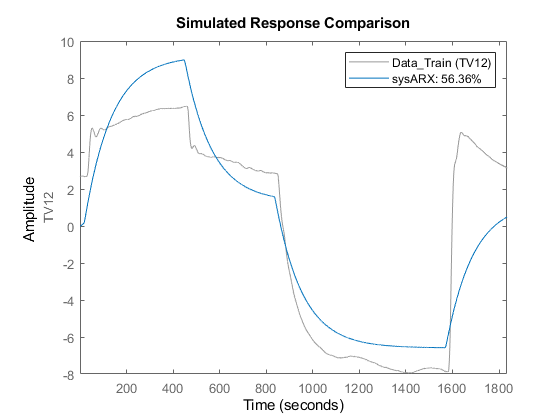

In [101]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

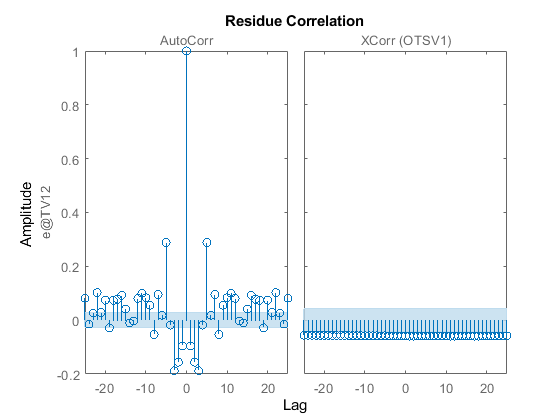

In [102]:
resid(data_test,sysARX)

# SI: ARMAX model

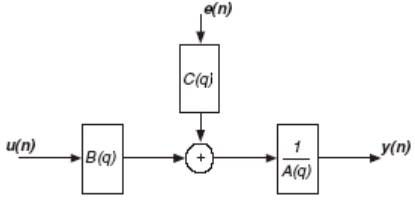 <br>
**sysARMAX = armax(data, [na nb nc nk])** $\quad$ ([link](https://se.mathworks.com/help/ident/ref/armax.html))
> na: Order of A(q)  <br>
> nb: Order of B(q)+1  <br>
> nc: Order of C(q)  <br>
> nk: Input-Output delay

## Set estimation options

In [109]:
opt = armaxOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 1000;
opt.SearchOptions.Tolerance = 1e-5;

## Estimate ARMAX model

In [110]:
na = 5;
nb = 5;
nc = 5;
nk = 0;
sysARMAX = armax(data_train, [na nb nc nk], opt)


sysARMAX =
Discrete-time ARMAX model: A(z)y(t) = B(z)u(t) + C(z)e(t)                           
  A(z) = 1 - 1.134 z^-1 - 1.556 z^-2 + 1.582 z^-3 + 1.046 z^-4 - 0.9369 z^-5        
                                                                                    
  B(z) = 0.0002136 - 0.000385 z^-1 - 1.265e-05 z^-2 + 0.000326 z^-3 - 0.0001404 z^-4
                                                                                    
  C(z) = 1 - 0.8044 z^-1 - 1.512 z^-2 + 1.049 z^-3 + 0.9096 z^-4 - 0.6185 z^-5      
                                                                                    
Sample time: 0.2 seconds
  
Parameterization:
   Polynomial orders:   na=5   nb=5   nc=5   nk=0
   Number of free coefficients: 15
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                
Estimated using ARMAX on time domain data "Data_Train".
Fit to estimation data: 99.79% (prediction focus)      
FPE: 0.0001469

## Advice on the estimated model

In [111]:
advice(sysARMAX, data_test)

                                                                                                                                                                                                                        
There is no indication of significant errors in the model dynamics.                                                                                                                                                     
                                                                                                                                                                                                                        
There is a very strong indication that the residuals are not white. To get a 
good noise model you need to increase the orders associated with the noise 
parameters, or just increase the order of a state-space model.
                                                                                                                                    

## Error Analysis ARMAX Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [112]:
% generate reference output
y_armax_ref = data_train.y;

% generate estimated output
y_armax_est = sim(sysARMAX, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_armax_est.y, y_armax_ref, cost_func)


fit =

    0.4073




#### Compare

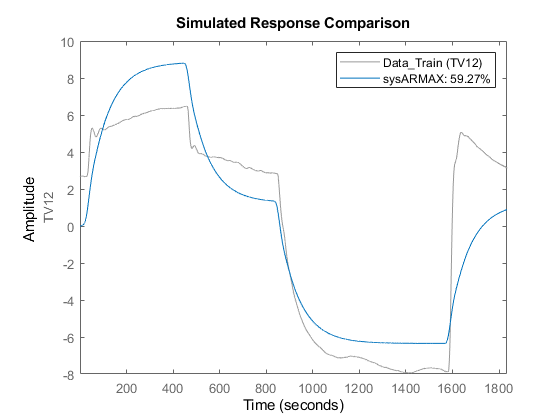

In [113]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysARMAX, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

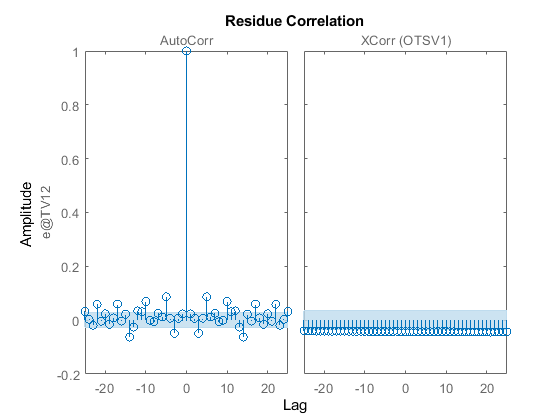

In [114]:
resid(data_test, sysARMAX)

# SI: BJ Model

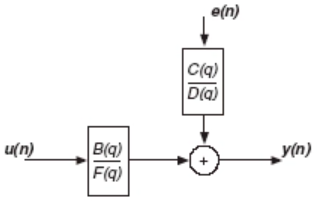 <br>
**sysBJ = bj(data, [nb nc nd nf nk])** $\quad$ ([link](https://se.mathworks.com/help/ident/ref/bj.html))
> nb: Order of B(q)+1  <br>
> nc: Order of C(q)+1  <br>
> nd: Order of D(q)+1  <br>
> nf: Order of F(q)+1  <br>
> nk: Input-Output delay

## Set estimation options

In [146]:
opt = bjOptions;
opt.Focus = 'prediction';
opt.SearchOptions.MaxIterations = 1000;
opt.SearchOptions.Tolerance = 1e-5;

## Estimate BJ Model

In [147]:
nb = 1;
nc = 2;
nd = 2;
nf = 2;
nk = 1;

sysBJ = bj(data_train, [nb nc nd nf nk], opt, 'IODelay', 20)


sysBJ =
Discrete-time BJ model: y(t) = [B(z)/F(z)]u(t) + [C(z)/D(z)]e(t)
  B(z) = 2.253e-05 z^-1                                         
                                                                
  C(z) = 1 - 1.67 z^-1 + 0.7588 z^-2                            
                                                                
  D(z) = 1 - 1.994 z^-1 + 0.9938 z^-2                           
                                                                
  F(z) = 1 - 1.99 z^-1 + 0.9903 z^-2                            
                                                                
Input delays (listed by channel): 20                            
Sample time: 0.2 seconds
  
Parameterization:
   Polynomial orders:   nb=1   nc=2   nd=2   nf=2   nk=1
   Number of free coefficients: 7
   Use "polydata", "getpvec", "getcov" for parameters and their uncertainties.

Status:                                             
Estimated using BJ on time domain data "Data_Train".
Fit to estimation 

## Advice on the estimated model

In [148]:
advice(sysBJ, data_test)

                                                                                                                                                                                                                        
There is no indication of significant errors in the model dynamics.                                                                                                                                                     
                                                                                                                                                                                                                        
There is a very strong indication that the residuals are not white. To get a 
good noise model you need to increase the orders associated with the noise 
parameters, or just increase the order of a state-space model.
                                                                                                                                    

## Error Analysis BJ Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [149]:
% generate reference output
y_bj_ref = data_train.y;

% generate estimated output
y_bj_est = sim(sysBJ, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_bj_est.y, y_bj_ref, cost_func)


fit =

    0.4012




#### Compare

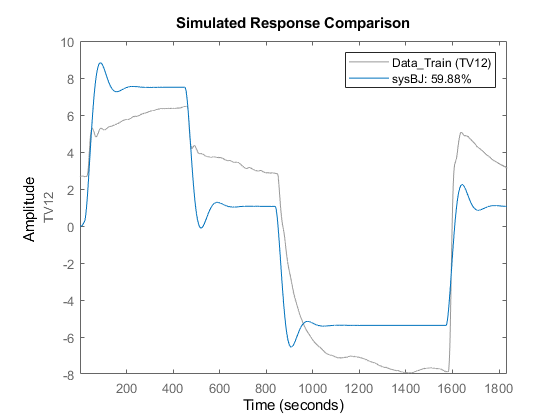

In [150]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysBJ, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

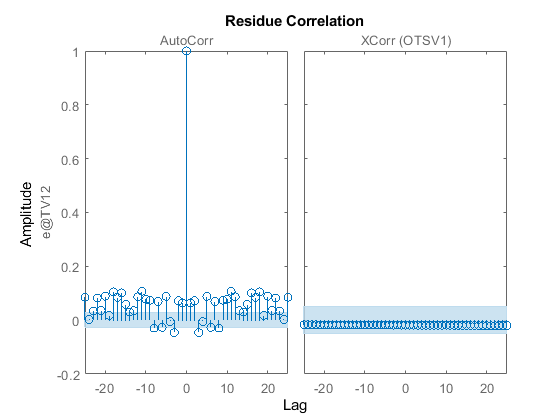

In [151]:
resid(data_test, sysBJ)

# SI: Process Model

**sysPXD = tfest(*data*, *'PXD*')** $\quad$ ([link](https://se.mathworks.com/help/ident/process-models.html)) <br>

A process model can go up to a max 3rd-order <br>
* $P1D = \frac{K_p}{1+T_{p1}s} e^{-T_{d}s}$ (1st order) <br>
* $P2D = \frac{K_p}{(1+T_{p1}s)(1+T_{p2}s)} e^{-T_{d}s}$ (2nd order)<br>
* $P3D = \frac{K_p}{(1+T_{p1}s)(1+T_{p2}s)(1+T_{p3}s)} e^{-T_{d}s}$ (3rd order)<br>
> $K_p$: proportional gain <br>
> $T_{p1}, T_{p2}, T_{p3}$: time constant of the real pole <br>
> $T_{d}$: transport delay <br>

## Set estimation options ([link](https://se.mathworks.com/help/ident/ref/procestoptions.html))
Disturbance Model
> $y = G(s)u + H(s)e$ <br>
* none — $H$ is fixed to one <br>
* estimate: $H$ is treated as an estimation parameter. The software uses the value of the NoiseTF property as the initial guess <br>
* ARMA1: The software estimates $H$ as a 1st-order ARMA model <br>
> $\frac{1+cs}{1+ds}$ <br>
* ARMA2: The software estimates $H$ as a 2nd-order ARMA model <br>
> $\frac{1+c_{1}s+c_{2}s^{2}}{1+d_{1}s+d_{2}s^{2}}$ <br>
* fixed: The software fixes the value of the NoiseTF property of the idproc model as the value of $H$ <br>

In [135]:
opt = procestOptions;
opt.DisturbanceModel = 'ARMA1';
opt.Focus = 'prediction';

## Set system initial condition  ([link](https://se.mathworks.com/help/ident/ref/idproc.html), [heatExchangerExample](https://se.mathworks.com/help/ident/ug/estimating-transfer-function-models-for-a-heat-exchanger.html))

In [136]:
sysInit = idproc('P1D');
sysInit.TimeUnit    = 'seconds';
sysInit.Structure.Kp.Value    = 1;
sysInit.Structure.Kp.Minimum  = 0;
sysInit.Structure.Tp1.Value   = 1;
sysInit.Structure.Tp1.Maximum = 10;
sysInit.Structure.Td.Value    = 0.2;
sysInit.Structure.Td.Minimum  = 0;
sysInit.Structure.Td.Maximum  = 1;

## Estimate Process Model

In [137]:
sysP1D = procest(data_train, 'P1D')


sysP1D =
Process model with transfer function:
             Kp                      
  G(s) = ---------- * exp(-Td*s)     
          1+Tp1*s                    
                                     
        Kp = 0.23236                 
       Tp1 = 36.141                  
        Td = 10.082                  
                                     
Parameterization:
    {'P1D'}
   Number of free coefficients: 3
   Use "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                  
Estimated using PROCEST on time domain data "Data_Train".
Fit to estimation data: 62.4%                            
FPE: 4.526, MSE: 4.523                                   



## Add Disturbance Model

In [153]:
opt = procestOptions('DisturbanceModel','ARMA1');
sysP1D_noise = procest(data_train,sysInit,opt)


sysP1D_noise =
Process model with transfer function:
             Kp                      
  G(s) = ---------- * exp(-Td*s)     
          1+Tp1*s                    
                                     
        Kp = 0.22006                 
       Tp1 = 10                      
        Td = 0.0014                  
                                     
Parameterization:
    {'P1D'}
   Number of free coefficients: 5
   Use "getpvec", "getcov" for parameters and their uncertainties.

Status:                                                  
Estimated using PROCEST on time domain data "Data_Train".
Fit to estimation data: 56.47% (prediction focus)        
FPE: 6.069, MSE: 6.063                                   



## Advice on the estimated model

In [138]:
advice(sysP1D, data_test)

                                                                                                                                                                                                                                                                                                                              
There is a very strong indication that the dynamics of the model is not 
adequately described.                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                                                                              
A first general advice is to run RESID(VDAT

## Error Analysis Process Model

### Normalised Root Mean Square Error (NRMSE)
$RMSE = \sqrt{\frac{\Sigma_{i=1}^{N}(y_{i}-\hat{y_{i}})^2}{N}}$ $\qquad$  $NRMSE = \frac{RMSE}{\bar{y}}$

In NRMSE, we try to find the goodness of fit between observed and estimated outputs of the estimated model. There are two ways to do a NRMSE analysis. ([link](https://se.mathworks.com/help/ident/ref/goodnessoffit.html#mw_3c7ec9a5-4198-4129-9f89-588593935a1c)) <br>
1. goodnessofFit() <br>
> returns the goodness of fit between the test data x and the reference data xref using the cost function cost_func. fit is a quantitative representation of the closeness of x to xref
2. compare() <br>
> compare uses the NRMSE cost function, and expresses the fit percentage using the one's complement of the error norm. <br>
> The fit relationship between compare and goodnessOfFit is therefore fit compare =(1−fitgof)∗100.

--> A compare result of 100% is equivalent to a goodnessOfFit result of 0.

#### Goodness of Fit

In [139]:
% generate reference output
y_pro_ref = data_train.y;

% generate estimated output
y_pro_est = sim(sysP1D, data_train(:, [], :));

% select cost function
cost_func = 'NRMSE';

% Goodness of Fit
fit = goodnessOfFit(y_pro_est.y, y_pro_ref, cost_func)


fit =

    0.3760




#### Compare

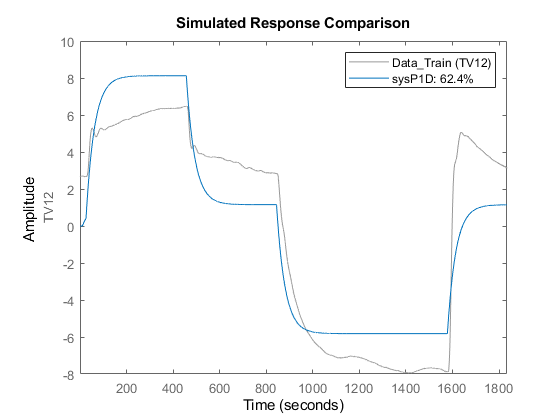

In [156]:
% Specify an initial condition of zero to match the initial condition that goodnessOfFit assumes
opt = compareOptions('InitialCondition','z');   % 'z' : zero initial conditions
compare(data_train, sysP1D, opt);

### Residual Analysis
**Auto-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (Y_i-\bar{Y})(Y_{i+k}-\bar{Y})}{\sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}$
> $r_k$     = Autocorrelation at lag k   <br>
> $Y_i$     = Data output at timestamp i <br>
> $\bar{Y}$ = Output sample mean         <br>
> $N$ = Total number of data points      <br> <br>

**Cross-correlation** <br>
$r_k = \frac{\sum\limits_{i=1}^{N-k} (X_i-\bar{X})(Y_{i+k}-\bar{Y})}{\sqrt{\sum\limits_{i=1}^{N}(X_i-\bar{X})^2 \sum\limits_{i=1}^{N}(Y_i-\bar{Y})^2}}$
> $r_k$ = Cross-correlation at lag k <br>
> $X_i$ = X variable value at timestamp i <br>
> $Y_i$ = Y variable value at timestamp i <br>
> $\bar{X}$ = X variable sample mean  <br>
> $\bar{Y}$ = Y variable sample mean  <br>
> $N$ = total number of data points

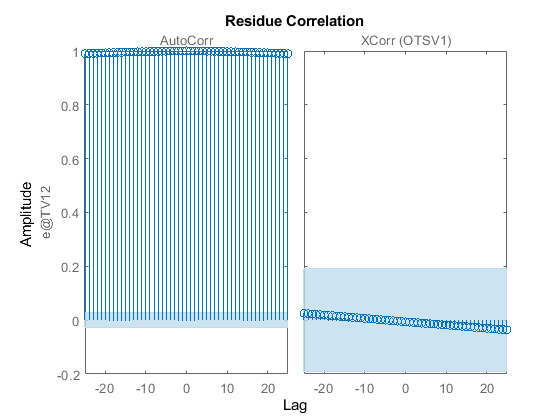

In [141]:
resid(data_test, sysP1D)